### This kernel is forked from https://www.kaggle.com/bminixhofer/aggregated-features-lightgbm . I have done some changes to get better score 

In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib_venn import venn2, venn2_circles
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold



sns.set()
%matplotlib inline

NFOLDS = 5
SEED = 42


/home/g492652607/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Loading


In [2]:
train = pd.read_csv('/home/g492652607/data/train.csv')
test = pd.read_csv('/home/g492652607/data/test.csv')
gp = pd.read_csv('/home/g492652607/data/aggregated_features.csv') 
train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp
gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,1


# Feature Engineering
### Text cleaning does not help So, I am commenting them

In [3]:
blend = pd.read_csv('/home/g492652607/data/blend.csv') 
train=train.merge(blend, on='item_id', how='left')
test=test.merge(blend, on='item_id', how='left')

img_t=pd.read_csv('/home/g492652607/data/test_0.csv')
img0=pd.read_csv('/home/g492652607/data/train-0.csv')
img1=pd.read_csv('/home/g492652607/data/train-1.csv')
img2=pd.read_csv('/home/g492652607/data/train-2.csv')
img4=pd.read_csv('/home/g492652607/data/train-4.csv')
img3=pd.read_csv('/home/g492652607/data/train-3.csv')
img=pd.concat([img_t,img0,img1,img2,img3,img4],axis=0)
img['image']=list(img['image'].str.split('.').str[0])
train=train.merge(img, on='image', how='left')
test=test.merge(img, on='image', how='left')


In [4]:
img.drop('image',axis=1,inplace=True)
img_col=list(img.columns)

In [5]:
print(train.columns)

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability',
       'avg_days_up_user', 'avg_times_up_user', 'n_user_items', 'rnn_pred',
       't', 'd', 'ridge_pred', 'cb_pred', 'user_price_aver', 'user_price_std',
       'user_seq_aver', 'user_seq_std',
       'user_id_parent_category_name_category_name_count',
       'user_id_parent_category_name_category_name_aver_pri',
       'region_city_parent_category_name_category_name_count', 'dullness',
       'whiteness', 'average_pixel_width', 'dominant_red', 'dominant_green',
       'dominant_blue', 'average_red', 'average_green', 'average_blue',
       'image_size', 'width', 'height', 'blurrness'],
      dtype='object')


In [6]:
for df in [train, test]:
    df['description'].fillna('unknowndesc', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.weekday
 #   df['dayofmonth'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
        
    for col in img_col:
        df[col].fillna(-1, inplace=True)

In [7]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=2)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=17000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape


((1503424, 105957), (1503424, 17000))

In [8]:
target = 'deal_probability'
predictors = [
    'num_desc_punct',
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number', 'user_price_aver', 'user_price_std', 'user_seq_aver', 'user_seq_std',
    'user_id_parent_category_name_category_name_count', 
    'user_id_parent_category_name_category_name_aver_pri',
    'region_city_parent_category_name_category_name_count','rnn_pred','t','d','ridge_pred','cb_pred'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical+img_col

In [9]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    train[feature].fillna('unknown',inplace=True)
    test[feature].fillna('unknown',inplace=True)
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


# Hyper Parameter Tuning

### I did it on cloud so I m just commenting it out to save time

In [10]:
# def objective(space):
#     mod = lgb.LGBMRegressor(n_estimators = 5000, 
#             num_leaves = int(space['num_leaves']),
#             subsample = space['subsample'],min_child_weight = space['min_child_weight'],
#             colsample_bytree=space['colsample_bytree'],
#             learning_rate =space['learning_rate'],n_jobs=-1,
#                 )
# #     temp_train=copy.copy(newtrain)
#     folds=KFold(5,random_state=100)
#     fold_score=[]
#     i=1
#     st=time.time()
#     print('=================*=================')
#     print(space)
#     for train_index,test_index in folds.split(X=X):
#         mod.fit(X=X[train_index],y=y.values[train_index],eval_set=[ (X[test_index],y.values[test_index])],early_stopping_rounds=20,verbose=30,eval_metric='rmse')    
#         score=mod.best_score_.get('valid_0').get('rmse')
#         print('cv',i,': ', score)
#         i=i+1
#         fold_score.append(score)                
#     print("SCORE:") 
#     print(np.mean(fold_score))
#     print('time',time.time()-st)
#     return 1-np.mean(fold_score) 

# space ={
#     #'max_depth':hp.quniform('max_depth',2,10,1),
#     'num_leaves': hp.quniform('num_leaves', 200, 300, 4),
#     'min_child_weight': hp.quniform ('min_child_weight', 1, 2, 1),
#     'subsample': hp.quniform ('subsample', 0.8, .95,0.05),
#     'learning_rate': hp.quniform('learning_rate', 0.01,0.2,.03),
#    # A problem with max_depth casted to float instead of int with
#    # the hp.quniform method.
# #     'gamma': hp.quniform('gamma', 0, 0.6, 0.1),
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.7, .95, 0.05),
#    }  
# trials = Trials()
# best = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=80)
# print(best)

In [11]:
train["price"] = np.log(train["price"]+0.001)
train["price"].fillna(-999,inplace=True)
train["image_top_1"].fillna(-999,inplace=True)

test["price"] = np.log(test["price"]+0.001)
test["price"].fillna(-999,inplace=True)
test["image_top_1"].fillna(-999,inplace=True)


# LightGBM 


In [12]:
rounds = 20000
early_stop_rounds = 50
lgbm_params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 300,
#     'max_depth': 15,
    'learning_rate' : 0.021,
    'feature_fraction' : 0.6,
    'bagging_fraction' : .8,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 123002


In [13]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,height,blurrness,weekday,num_words_description,num_unique_words_description,num_words_title,num_unique_words_title,words_vs_unique_title,words_vs_unique_description,num_desc_punct
0,b912c3c6a6ad,e00f8ff2eaf9,19,1313,4,42,249,112,1219,Кокоби(кокон для сна),...,480.0,398.109961,1,7,7,3,3,100.0,100.0,2
1,2dac0150717d,39aeb48f0017,17,1233,2,22,122,112,1219,Стойка для Одежды,...,480.0,1014.604608,6,7,7,3,3,100.0,100.0,3
2,ba83aefab5dc,91e2f88dd6e3,16,1172,0,2,84,112,1219,Philips bluray,...,360.0,493.921065,0,17,17,2,2,100.0,100.0,5
3,02996f1dd2ea,bf5cccea572d,21,1557,4,42,38,112,1219,Автокресло,...,360.0,377.105718,5,3,3,1,1,100.0,100.0,1
4,7c90be56d2ab,ef50846afc0b,4,250,6,0,278,124,46,"ВАЗ 2110, 2003",...,360.0,557.351080,3,4,4,3,3,100.0,100.0,1


In [14]:
VALID = False

In [15]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

if VALID == True:
    train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=42)

    x_train = scipy.sparse.hstack([
            train_desc_counts[train_index],
            train_title_counts[train_index],
            train.loc[train_index, predictors]
    ], format='csr')
    y_train = train.loc[train_index, target]

    x_valid = scipy.sparse.hstack([
        train_desc_counts[valid_index],
        train_title_counts[valid_index],
        train.loc[valid_index, predictors]
    ], format='csr')
    y_valid = train.loc[valid_index, target]

     
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(x_train, y_train,
                    feature_name=list(feature_names),
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(x_valid, y_valid,
                    feature_name=list(feature_names),
                    categorical_feature = categorical)
     
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100)
    print("Model Evaluation Stage")
    del x_valid ; x_train; gc.collect()

else:
    # LGBM Dataset Formatting 
    X = scipy.sparse.hstack([
        train_desc_counts,
        train_title_counts,
        train.loc[: , predictors]
    ], format='csr')
    y = train.deal_probability
    
    lgtrain = lgb.Dataset(X, y.values,
                    feature_name=list(feature_names),
                    categorical_feature = categorical)
     # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=2200)
    
    del X; gc.collect()

del train,test
gc.collect()

/home/g492652607/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


16

Text(0.5,1,'Light GBM Feature Importance')

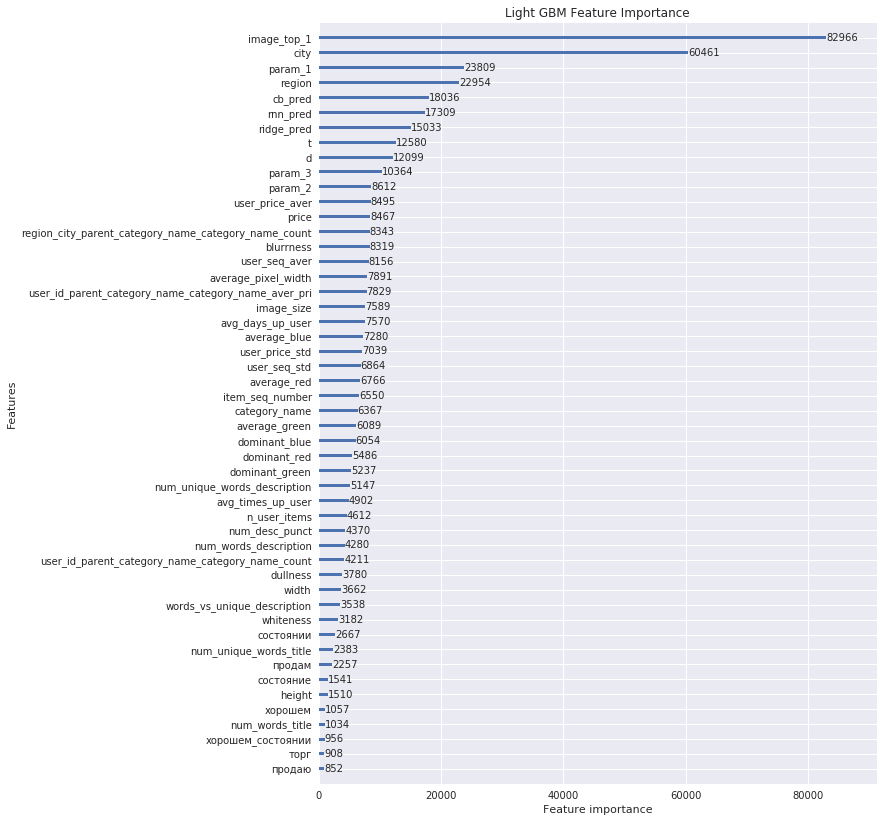

In [16]:
fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [17]:
subm = pd.read_csv('/home/g492652607/data/sample_submission.csv')
subm['deal_probability'] = np.clip(lgb_clf.predict(x_test), 0, 1)
subm.to_csv('baseline11.csv', index=False)